# CNN Skin Cancer Assignment
## Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data
**To do: Take necessary actions to read the data**

## Importing all the important libraries

In [1]:
# Import necessary libraries, modules and instantiation
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

## Filtering warnings

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Reading Skin Cancer Image Dataset

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab_Notebook/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab_Notebook/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Load the test dataset fully
test_ds = image_dataset_from_directory(
    directory=data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
# Lets check the shape of batch dataset
train_ds,val_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

## Visualize the data
**Todo, create a code to visualize one instance of all the nine classes present in the dataset** 

In [12]:
### your code goes here, you can use training or validation data to visualize
# lets iterate through first 5 batches of dataset
for images, labels in train_ds.take(5):
  unique_li = []
  unique_images = []
  # make a list of all unique images from each class
  for i in range(32):
    if class_names[labels[i]] not in unique_li:
      unique_li.append(class_names[labels[i]])
      unique_images.append((class_names[labels[i]],images[i]))
  # Check if images from all class are covered, if so then we dont need to check next batch, hence we can break the loop
  if len(unique_images)==9:
    print("Found",len(unique_images),"classes in batch")
    break

Found 9 classes in batch


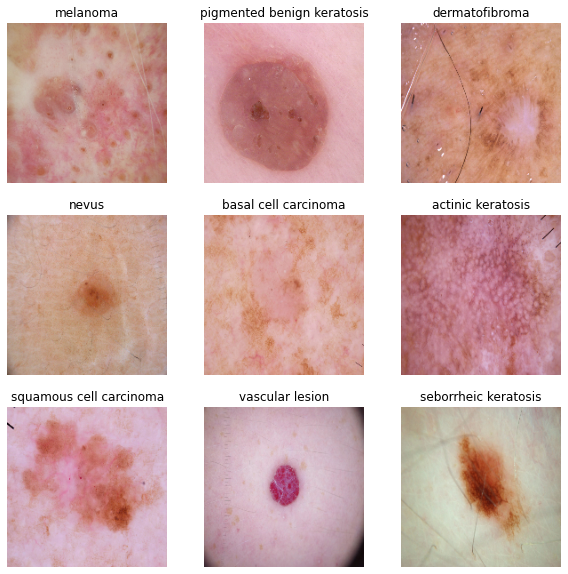

In [13]:
# plot image from unique images list
plt.figure(figsize=(10, 10))
# iterate through all unique images from each class and display using matplotlib
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(unique_images[i][1].numpy().astype("uint8"))
  plt.title(unique_images[i][0])
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model - Vanilla Model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
img_size = 180
# Build Normalization layer by rescaling between 0-1, lets also specify input shape with 180x180x3 as we will be using this in all future layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))
# Lets build sequential model with 3 conv layers with 16,32,64 filters, 3 max pooling , then flatten the layer , build a dense layer of 128 and conclude with softmax function layer for output 
model = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# Resizing the image to 180x180
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [18]:
# Lets train the model with batch size of 32
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 458s 2s/step - loss: 1.9270 - accuracy: 0.2985 - val_loss: 1.7153 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5959 - accuracy: 0.4291 - val_loss: 1.4677 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4377 - accuracy: 0.5028 - val_loss: 1.4987 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3582 - accuracy: 0.5151 - val_loss: 1.3380 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2011 - accuracy: 0.5826 - val_loss: 1.3408 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1060 - accuracy: 0.6071 - val_loss: 1.3939 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.0460 - accuracy: 0.6194 - val_loss: 1.3923 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing training results

In [19]:
# Building a generic function to visualize the accuracy so that it can be used for further evaluation
def plot_accuracy(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

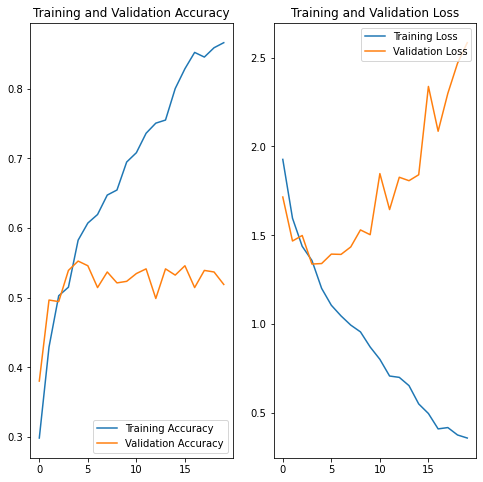

In [20]:
# Visualizing the vanilla model
plot_accuracy(history,epochs)

In [21]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.866071,0.519016,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


**Observation**

* The training accuracy with Vannila model came to be **87%** and validation accuracy **52%**. Since there is huge gap between training and validation accuracy, the model will not perform well on newer dataset.
* From the plot, we can say that with the increase in number of epochs, the training accuracy also increases however the validation accuracy starts reducing. This model is clearly **overfitting**.
* Also, in terms of loss - training loss decreases and validation loss increases with the increase in number of epochs.



## Data Augmentation

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Lets build a layer which performs just the random rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

Keeping Augmentation with just **RandomRotation** as itsmost useful parameter for image processing and object detection. Also, infected pictures in dataset have been taken from a particular angle but same infection could be seen at a different angle for others.

(-0.5, 179.5, 179.5, -0.5)

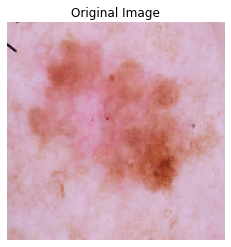

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Pick one of the image from the unique images list
import random
image = tf.expand_dims(unique_images[random.randint(0,9)][1], 0)
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

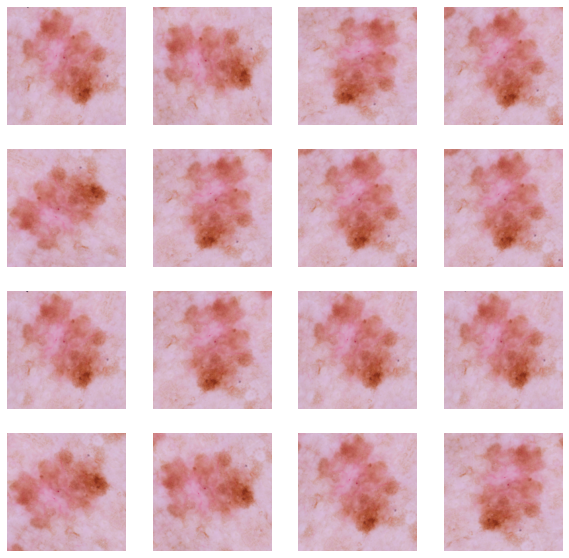

In [24]:
# Passing through the data augmentation layers and displaying the image to visualize how data is getting augmented 
augmented_image = data_augmentation(image)
plt.figure(figsize=(10, 10))
for i in range(16):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Building a model first with just an added augmentation layer and based on results will add dropout layer for better performance of model.

In [26]:
## Your code goes here
img_size = 180
# Building the sequential layers same as before with an extra data augmentation layer
model_augm1 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# resizing the layer
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [27]:
## Your code goes here
model_augm1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_augm1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
# Lets the fit the model with batch size of 32 and 20 epochs
history_augm1 = model_augm1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 4s 53ms/step - loss: 2.0196 - accuracy: 0.2355 - val_loss: 1.9513 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7873 - accuracy: 0.3354 - val_loss: 1.5981 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5892 - accuracy: 0.4381 - val_loss: 1.5296 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4391 - accuracy: 0.4810 - val_loss: 1.4317 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4060 - accuracy: 0.4983 - val_loss: 1.3983 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3613 - accuracy: 0.5145 - val_loss: 1.4220 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.2817 - accuracy: 0.5469 - val_loss: 1.4567 - val_accuracy: 0.4877
Epoch 8/20
56

### Visualizing the results

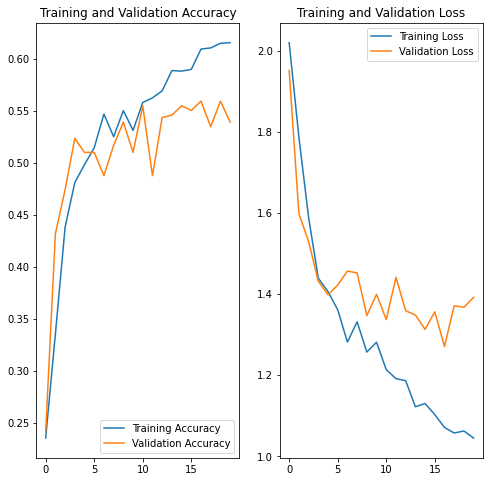

In [29]:
plot_accuracy(history_augm1,epochs)

In [30]:
# Lets store the accuracy in the DF
acc = history_augm1.history['accuracy']
val_acc = history_augm1.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Data Augmentation","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.866071,0.519016,20
0,Data Augmentation,0.615513,0.539150,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


**Observation**

* With above model training accuracy has reduced and test accuracy has improved a little but the difference between the two has reduced.
* However, still model is underfitting as the training accuracy is low.



## Create Model with Dropout
### Train by adding dropout
Lets evaluate model by adding dropout layer of 25%

In [31]:
# lets train by adding a dropout of 0.25
model_dropout = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model

In [32]:
## Your code goes here
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 resizing_2 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Fit the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_dropout = model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 4s 53ms/step - loss: 2.0877 - accuracy: 0.2333 - val_loss: 1.9449 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.7965 - accuracy: 0.3443 - val_loss: 1.6934 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5241 - accuracy: 0.4598 - val_loss: 1.5230 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4162 - accuracy: 0.4955 - val_loss: 1.4275 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4323 - accuracy: 0.4922 - val_loss: 1.3662 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3692 - accuracy: 0.5201 - val_loss: 1.5084 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.2977 - accuracy: 0.5285 - val_loss: 1.3255 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualize the results

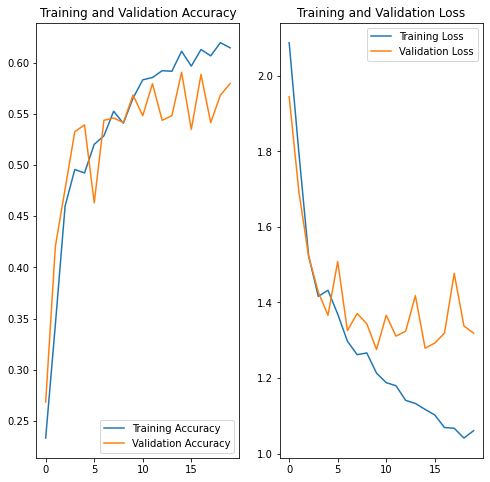

In [34]:
plot_accuracy(history_dropout,epochs)

In [35]:
# Storing the accuracy in the DataFrame
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Dropout","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.866071,0.519016,20
0,Data Augmentation,0.615513,0.539150,20
0,Dropout,0.614397,0.579418,20



**Observation**

* We can see that accuracy of training and validation did not have much affect after adding dropout layer, although making validation accuracy a bit closer to training
* Model is still underfitting even after adding dropout layer.
* Let's keep the dropout layer, just to add some regularization layer if there is some overfitting in future.



## Class Imbalance

**Todo: Find the distribution of classes in the training dataset.**

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
## Your code goes here.
# Lets initialize an empty dictionary
class_distr={}
# Go through all training dataset batches
for image_batch, labels_batch in train_ds:
  # prepare the count of images in each class
    for i in range(image_batch.shape[0]):
      if class_names[labels_batch[i]] in class_distr:
        class_distr[class_names[labels_batch[i]]]+=1
      else:
        class_distr[class_names[labels_batch[i]]]=1
# Display the distribution
class_distr

{'actinic keratosis': 92,
 'basal cell carcinoma': 309,
 'dermatofibroma': 77,
 'melanoma': 352,
 'nevus': 277,
 'pigmented benign keratosis': 370,
 'seborrheic keratosis': 58,
 'squamous cell carcinoma': 142,
 'vascular lesion': 115}

In [37]:
# Lets prepare the class distribution Dataframe
df_sample_distr = pd.DataFrame({"Class Name":class_distr.keys(), "Samples":class_distr.values()})
df_sample_distr.sort_values('Samples',ascending=False)

,Class Name,Samples
0,pigmented benign keratosis,370
4,melanoma,352
1,basal cell carcinoma,309
3,nevus,277
7,squamous cell carcinoma,142
2,vascular lesion,115
8,actinic keratosis,92
6,dermatofibroma,77
5,seborrheic keratosis,58


### Visualize Class Distribution

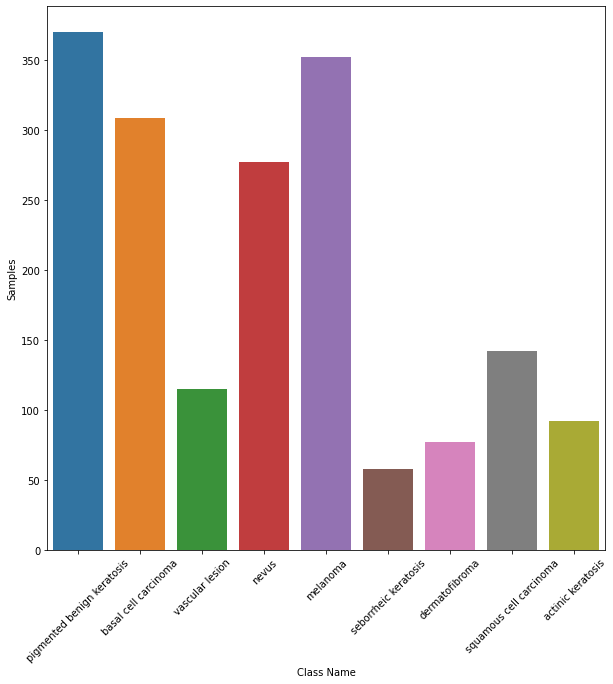

In [38]:
# Lets visualize Class Distribution
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(data=df_sample_distr,x='Class Name',y='Samples')
plt.xticks(rotation = 45) 
plt.show()

**Todo: Write your findings here:**
- Which class has the least number of samples?
- **Answer:** seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
- **Answer:** pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
# Specify the path to training dataset
path_to_training_dataset="/content/drive/MyDrive/Colab_Notebook/Train/"
import Augmentor
print("Please hold on for few minutes, as the augmenting takes time")
# Augment 1000 images per class to balance the dataset using Augmentor
for i in class_names:
    print("Augmenting image for class",i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Please hold on for few minutes, as the augmenting takes time
Augmenting image for class actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7CDD19E510>: 100%|██████████| 1000/1000 [00:51<00:00, 19.39 Samples/s]


Augmenting image for class basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7DC00E1B10>: 100%|██████████| 1000/1000 [00:43<00:00, 22.89 Samples/s]


Augmenting image for class dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D54AA51D0>: 100%|██████████| 1000/1000 [00:45<00:00, 22.01 Samples/s]


Augmenting image for class melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7D52EC8B90>: 100%|██████████| 1000/1000 [03:37<00:00,  4.60 Samples/s]


Augmenting image for class nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1028x753 at 0x7F7D53642D50>: 100%|██████████| 1000/1000 [03:22<00:00,  4.93 Samples/s]


Augmenting image for class pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7CDF0BE550>: 100%|██████████| 1000/1000 [00:43<00:00, 23.21 Samples/s]


Augmenting image for class seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7CDD0D6390>: 100%|██████████| 1000/1000 [01:39<00:00, 10.02 Samples/s]


Augmenting image for class squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7D549AF4D0>: 100%|██████████| 1000/1000 [00:44<00:00, 22.52 Samples/s]


Augmenting image for class vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebook/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D52F63390>: 100%|██████████| 1000/1000 [00:44<00:00, 22.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
# Counting the number of images added in output folder
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
# Get the list of all paths of images in output folder
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[0:5]

['/content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_3f33e527-33db-4b79-a835-5f73cc603349.jpg',
 '/content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_ee66da55-6143-4d00-bcfc-7d5f0e4034f9.jpg',
 '/content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_8fb817c9-181d-4289-a0cf-dd6f8e9fbfb1.jpg',
 '/content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_7e6c9ad7-319a-4885-bd39-3ebff7f34d27.jpg',
 '/content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_bc1d78c4-3002-4ae4-8254-65e8d5eb871d.jpg']

In [43]:
# Get the list of all class names for the above paths
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [44]:
# Creating a dictionary by combining the path and class name from above two
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
# Prepare Dataframe using the dictionary created above
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print("shape of new dataset",df2.shape)
df2.head()

shape of new dataset (9000, 2)


,Path,Label
0,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
1,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
2,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
3,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
4,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis


In [46]:
# Let's check if it has added 500 images to each class
df2['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

In [47]:
# Lets prepare a dataframe containing paths to original images present outside of output folder, 
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("one of the path to original dataset image",path_list[0])
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("lesion of one of the image",lesion_list[0])
dataframe_dict = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print("Shape of original dataset",df1.shape)
df1.head()

one of the path to original dataset image /content/drive/MyDrive/Colab_Notebook/Train/actinic keratosis/ISIC_0027802.jpg
lesion of one of the image actinic keratosis
Shape of original dataset (2239, 2)


,Path,Label
0,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
1,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
2,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
3,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
4,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis


In [48]:
# Check class distribution again
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [49]:
# Lets merge the original and new augmented images dataframe
new_df = df1.append(df2)
print("Shape of merged dataset",new_df.shape)
new_df.head()

Shape of merged dataset (11239, 2)


,Path,Label
0,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
1,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
2,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
3,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis
4,/content/drive/MyDrive/Colab_Notebook/Train/ac...,actinic keratosis


In [50]:
# Lets check the final class distribution of the dataset
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
# Lets reinitialize the parameters
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
# Lets respecify the path to training dataset and reload the augmented images with original images
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="/content/drive/MyDrive/Colab_Notebook/Train"
# Split the training dataset to get training set 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [53]:
# Split the training dataset to get validation set 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [54]:
# Lets check the classes again to re confirm if its those 9 classes again
class_names_new = train_ds.class_names
num_classes1 = len(class_names_new)
print("Classes",class_names_new)
print("Number of classes",num_classes1)

Classes ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes 9


### Create Model with class balance

#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here
img_size = 180
# lets build layer with same layer as before
model_augm2 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),# Adding one more layer with 128 to improve the accuracy even more
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
# Compile the model
model_augm2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_augm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing_3 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [57]:
epochs = 30
## Your code goes here, use 50 epochs.
history_augm2 = model_augm2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/30
281/281 [==============================] - 62s 212ms/step - loss: 1.7085 - accuracy: 0.3324 - val_loss: 1.4746 - val_accuracy: 0.4219
Epoch 2/30
281/281 [==============================] - 60s 210ms/step - loss: 1.4210 - accuracy: 0.4523 - val_loss: 1.3243 - val_accuracy: 0.5020
Epoch 3/30
281/281 [==============================] - 60s 211ms/step - loss: 1.3290 - accuracy: 0.4893 - val_loss: 1.2620 - val_accuracy: 0.5385
Epoch 4/30
281/281 [==============================] - 60s 211ms/step - loss: 1.2186 - accuracy: 0.5281 - val_loss: 1.2522 - val_accuracy: 0.5113
Epoch 5/30
281/281 [==============================] - 60s 210ms/step - loss: 1.1649 - accuracy: 0.5585 - val_loss: 1.1300 - val_accuracy: 0.5768
Epoch 6/30
281/281 [==============================] - 60s 211ms/step - loss: 1.0769 - accuracy: 0.5905 - val_loss: 1.0092 - val_accuracy: 0.6204
Epoch 7/30
281/281 [==============================] - 60s 211ms/step - loss: 1.0085 - accuracy: 0.6171 - val_loss: 0.9337 - val_ac

#### **Todo:**  Visualize the model results

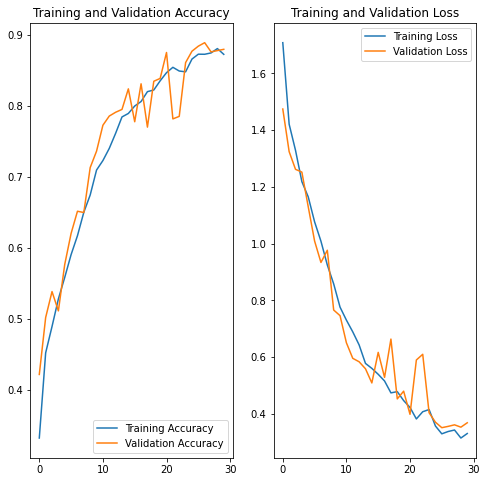

In [58]:
plot_accuracy(history_augm2,epochs)

### Summary and Final Observation

#### Summary Table

In [59]:
# Lets store the accuracy in the DF
acc = history_augm2.history['accuracy']
val_acc = history_augm2.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Class Imbalance","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.866071,0.519016,20
0,Data Augmentation,0.615513,0.539150,20
0,Dropout,0.614397,0.579418,20
0,Class Imbalance,0.872331,0.879395,30


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




**Observation**

* According to the table above, the training accuracy has increased to 87% after resolving the issue of Class Imbalance and increasing the number of images with minor changes using augmentor. As a result, we can state that we were successful in resolving the issue of underfitting. 

* Validation accuracy is also 87%, which is very close to training accuracy, indicating that no overfitting has occurred.

* When compared to the accuracy of the previous models, class re-balancing significantly improved accuracy.

* More data augmentation approaches were used to test the model, but the accuracy was greatly lowered due to changing variations between images.
However, this can be fixed by training it for a larger number of epochs. 

